In [1]:
import Pkg

In [2]:
Pkg.add("Enzyme")
Pkg.add("Distributions")
Pkg.add("SpecialFunctions")
Pkg.add("CairoMakie")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [3]:
using Distributions
using SpecialFunctions
using CairoMakie

All distances should eventually be in terms of Rg for mass independence in a black hole, currently they are in units of cm^2

### Structures
Let's first define all important structures. We are particularly concerned with the shape of the corona and photon states. Let's initalize shapes, a photon structure and define a corona structure that contains information about its geometry and fundamental properties.

In [4]:
abstract type Shape end

struct Sphere{Float64} <: Shape #simple spherical blob
    radius :: Float64
    location :: Float64 #height from the singularity along the axis of black hole rotation
end

struct Cylinder{Float64} <: Shape #the slab type coronae
    radius :: Float64 #radius of the slab
    height :: Float64 #height of the slab
    location :: Float64 #height from the singularity along the axis of black hole rotation
end

struct Photon{Float64}
    ν :: Vector{Float64} #4 momentum vector
    x :: Vector{Float64} # p_μ (actual location)
    scatter :: Vector{Float64} #last scatter location
end

struct Corona{Float64}
    temp :: Float64 #temperature of electrons in keV
    τ :: Float64 #mean free path (can be used to back calculate density) 
    geometry :: Shape
end

abstract type InputSpectrum end

struct Synchotron{Float64} <: InputSpectrum
    distribution :: Vector{Float64} #photon distribution
    lorentz :: Vector{Float64} #lorentz factor grid
    origin :: Float64 #flag to indicate origin
end

struct Thermal{Float64} <: InputSpectrum
    distribution :: Vector{Float64} #photon distribution
    lorentz :: Vector{Float64} #lorentz factor grid
    origin :: Float64 #flag to indicate origin
end

Let's also define how to randomly sample a photon origin point from their surface - all photons begin at the surface and then collide with photons in the corona before exiting.

In [147]:
function randomsurfacebin(geometry::Sphere)
    θ = rand()*π #random angle
    ϕ = rand()*π #random azimuth
    return (θ,ϕ)
end

function randomsurfacebin(geometry::Cylinder)
    θ = rand()*π #random angle
    h = rand()*geometry.height. #random height
    return (θ,h)
end

function randomvolumebin(geometry::Sphere)
    θ = rand()*π #random angle
    ϕ = rand()*π #random azimuth
    r = rand()*geometry.radius #random radius
    return (θ,ϕ,r)
end

function randomvolumebin(geometry::Cylinder)
    θ = rand()*π #random angle
    h = rand()*geometry.height #random height
    r = rand()*geometry.radius #random radius
    return (θ,h,r)
end

function superphotoninit(x_μ::Vector{Float64},v_μ::Vector{Float64},scalar::Int)
    superphoton = Vector{Photon}(undef,scalar)
    for i in 1:scalar
        superphoton[i] = Photon(v_μ,x_μ)
    end
    return superphoton
end

function weighting(geometry::Sphere)
    θ = range(0,π,100) #angle
    ϕ = range(0,2π,100) #azimuth
    weighting = Matrix{Float64}(ones(100,100))
    return (θ, ϕ), weighting
end

function photonmomentum(x_μ::Vector{Float64})
    return [-1,-1,0,0]
end

function photongeneration(n_photons::Int,geometry)
    grid, weighting = weighting(geometry)
end

function tracking(photon::Photon,step_size::Int)
    
    

randomsurfacebin (generic function with 2 methods)

Let's also define any distributions that we require

In [94]:
function maxwelljuttner(γ,θ)
    β = sqrt(1 - (1/γ^2)) # = v/c
    dist = ((γ^2*β)/(θ*besselk(2,1/θ)))*exp(-γ/θ)
    return dist
end 

maxwelljuttner (generic function with 1 method)

Let's also plot those distributions

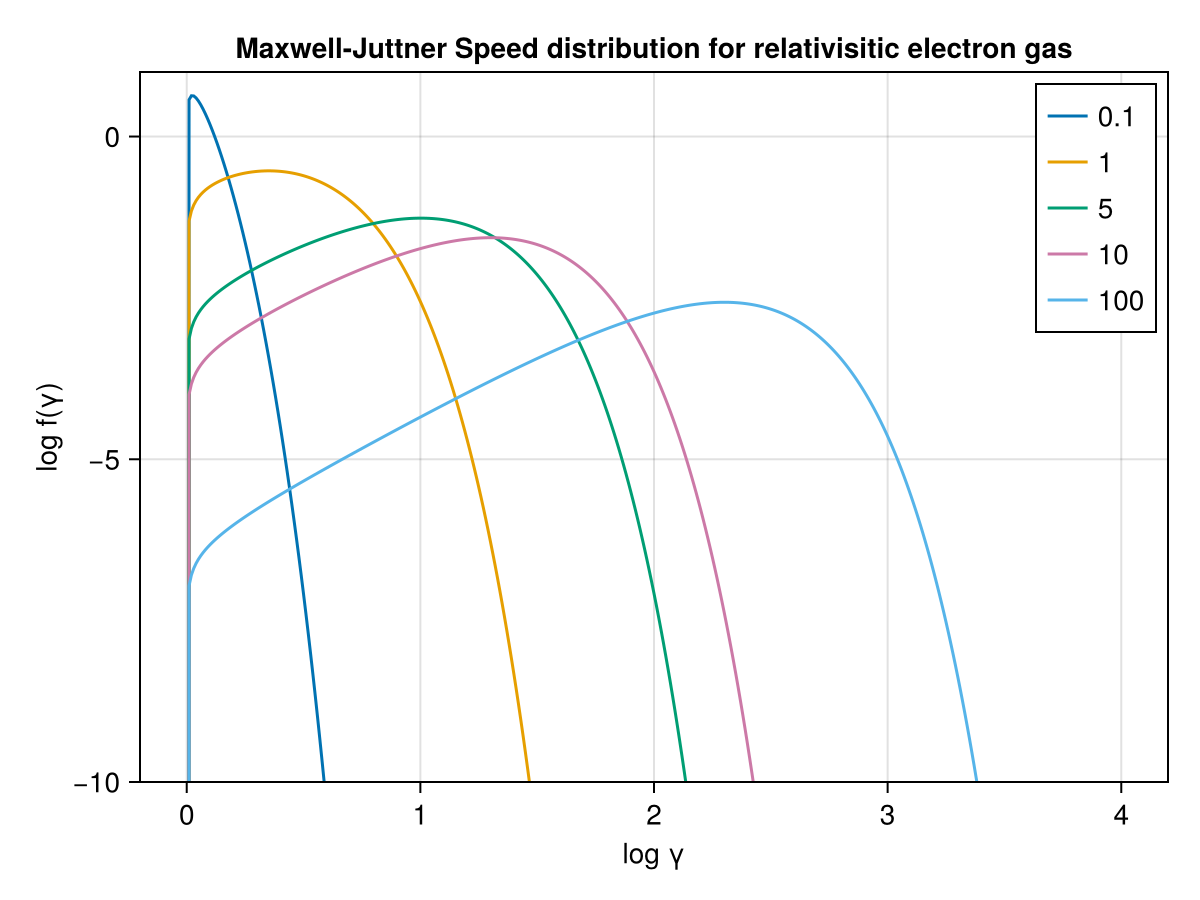

In [136]:
lorentz = 10.0.^(0:0.01:4)
thetas = (0.1,1,5,10,100)
f = Figure()
ax = Axis(f[1,1],
          xlabel = "log γ", 
          ylabel = "log f(γ)",
          title = "Maxwell-Juttner Speed distribution for relativisitic electron gas")
for θ in thetas
    prob = Array{Float64}(undef, size(lorentz)[1])
    for (i,factor) in enumerate(lorentz)
        temp_prob = (maxwelljuttner(factor,θ))
        if temp_prob < 1e-100
            temp_prob = 1e-100
        end
        prob[i] = temp_prob
    end
    lines!(log10.(lorentz),log10.(prob),label="$θ")
end
ylims!(-10,1)
axislegend(ax)
current_figure()

### Monte Carlo simulations
Fundamentally, any comptonisation code will require monte carlo simulations of many photons entering the gas and eventually exiting after undergoing scattering. Many photons will be from outside the corona in this case (usually emitted from the disk) but nominally, some photons could be emitted by electrons in the corona itself via synchotron radiation. This is somewhat difficult to model as it requires knowledge of the magnetic field within the corona, and it's unlikely to be a large contributor, so we'll ignore it in these simulations.

The following establishes photon scattering functions, as well as photon intialisation.

In [ ]:
function randomτ()
    τ = -log(rand())
    return τ
end

function scatterdistance(photon::Photon,corona::Corona)
    σ=6.65e-25           # Thomson cross section
    τ = randomτ()
    electron_density=corona.τ/(corona.geometry.radius*σ)
    distance=τ/(σ*electron_density)
    return distance
end

function scatterlocation(photon::Photon,corona::Corona)
    # ...path-length:
    distance = distance_of_scatter(mc_parms)
    
    # ...in direction:
    photon_direction=photon.ν[2:end]./photon.ν[1]
    
    # Update photon position with the new location
    photon.scatter = photon.scatter + distance*photon_direction
end

function randomdirection(number::Int)
    phi= 2. * π * rand(number)
    cos_phi=cos(phi)
    sin_phi=sin(phi)
    cos_theta=2. *rand(number)-1
    sin_theta=sqrt(1 - cos_theta^2)
    direction = [sin_theta*cos_phi,sin_theta*sin_phi,cos_theta]
    return direction
end

function photonorigin(distribution::Dist,corona::Corona)
    if distribution.origin == 1.0 #if origin is surface
        location = randomsurfacebin(corona.geometry)
    elseif distribution.origin == 2.0 #if origin is within volume
        location = randomvolumebin(corona.geometry)
    end
    return location
end
        
    